In [34]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph
from libs.model import HGPforecaster, PiecewiseLinearChangepoints

import theano
theano.config.compute_test_value='raise'

In [2]:
# Read in the data
INPUT_DIR = '../benchmark/m5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

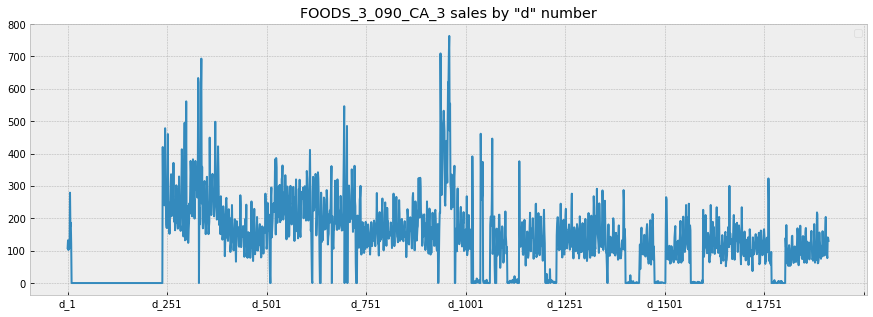

In [5]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

In [8]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

Number of unique items: 3049
Number of unique department: 7
Number of unique categories: 3
Number of unique stores: 10
Number of unique states: 3


In [ ]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'item_id', 'day']).sum('value').reset_index()

days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

stv['Date'] = stv['Date'].astype('datetime64[ns]')
stv.dtypes

stv = stv.loc[stv['cat_id']=='FOODS']

# Transform in weekly data

stv_weekly = stv.groupby(['dept_id', 'store_id', 'state_id', 'item_id']).resample('W', on='Date')['value'].sum()

# Build the structure to then apply the grouping transformation

stv_pivot = stv_weekly.reset_index().pivot(index='Date',columns=['dept_id', 'cat_id', 'store_id', 'state_id', 'item_id'], values='value')
stv_pivot = stv_pivot.fillna(0)

groups_input = {
    'Department': [0],
    'Store': [1],
    'State': [2],
    'Item': [3]
}

In [35]:
# The dataset results from the removal of item_id (groupby by the ohter groups) and by downsampling to weekly data (the dataset was daily)

groups = generate_groups_data_flat(stv_pivot, groups_input, seasonality=7, h=30)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 359
Total number of points: 389
Seasonality: 7
Forecast horizon: 30


In [36]:
# Instantiate the model class
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints = 4,
                  piecewise_out=True)

In [ ]:
# Prior checks
m.prior_predictive_checks()
visualize_prior(groups, m.prior_checks, 8)

In [ ]:
# Fit and predict
m.fit_vi()
m.predict()

In [ ]:
# Visualize your predictions and credible intervals
visualize_predict(groups, m.pred_samples_predict, 8)

In [ ]:
# Print the overall resuls
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)